In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
os.chdir("..")
from model import run_experiments
from model.config.params import build_params
import numpy as np

df = run_experiments(["Base", "Base"])


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (2, 730, 128, 2, 25)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (365, 64, 1, 25)
     Simulation 1: (Timesteps, Params, Runs, Sub-States) = (365, 64, 1, 25)
Execution Method: local_simulations
Execution Mode: parallelized
2023-12-12 10:44:53.940597
2023-12-12 10:44:53.945709


## Extra KPIs

In [ ]:
df['n_servicers'] = df['Servicers'].apply(len)
df['n_applications'] = df['Applications'].apply(len)
df['n_gateways'] = df['Gateways'].apply(len)
df['n_services'] = df['Services'].apply(len)

df['n_understaked_servicers'] = df['understaked_servicers'].apply(len)
df['n_understaked_gateways'] = df['understaked_gateways'].apply(len)
df['n_understaked_applications'] = df['understaked_applications'].apply(len)

# Get unique servicers
unique_servicers = {}
for key in df['key'].unique():
    unique_servicers[key] = {}
    df_mini = df[df['key'] == key]
    for x in df_mini["Servicers"]:
        for y in x:
            unique_servicers[key][y.id_number] = y

## Simulation KPIs

In [ ]:
simulation_kpis = []

# Minting rate
simulation_kpis.append(df.groupby('key')['POKT_net_mint'].sum() / df.groupby('key')['floating_supply'].first())

# Average of KPI C
simulation_kpis.append(df.groupby('key')['kpi_c'].mean())

# Put the two together to start our dataframe
simulation_kpis = pd.concat(simulation_kpis, axis=1)
simulation_kpis.columns = ["Net Minting Rate", "KPI C"]

# Add in metadata
simulation_kpis = simulation_kpis.join(df.groupby(['key'])[['Experiment Name', 'State Set', 'Params Set']].last())

# Add the parameters in
params = simulation_kpis["Params Set"].apply(build_params).apply(pd.Series)
params.columns = "param_" + params.columns


# Add in KPI 8, average slashing
kpi8 = {}
for key in unique_servicers:
    servicers = unique_servicers[key]
    slashes = [sum(x.slashing_history.values()) for x in servicers.values() if len(x.slashing_history) > 0]
    n = len(slashes)
    total_slashed = -sum(slashes)
    if n > 0:
        kpi8[key] = total_slashed / n
    else:
        kpi8[key] = None
simulation_kpis["KPI 8"] = pd.Series(kpi8)

# Add in KPI E
kpi_e = {}
for key in unique_servicers:
    servicers = unique_servicers[key]
    slashing_cost = sum([sum(x.slashing_history.values()) for x in servicers.values()])
    jailing_cost = -sum([sum(x.jail_lost_revenue_history.values()) for x in servicers.values()])
    kpi_e[key] = np.exp(- slashing_cost / jailing_cost)
simulation_kpis["KPI E"] = pd.Series(kpi_e)

In [ ]:
servicer_npvs = {}
for key in unique_servicers:
    servicers = unique_servicers[key]

## Basic Line Graphs

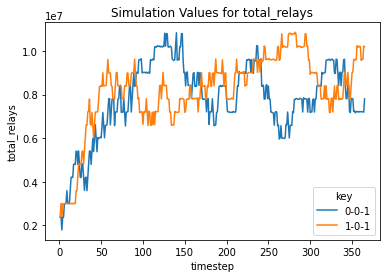

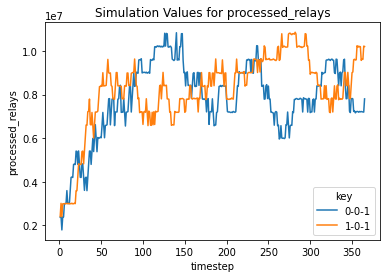

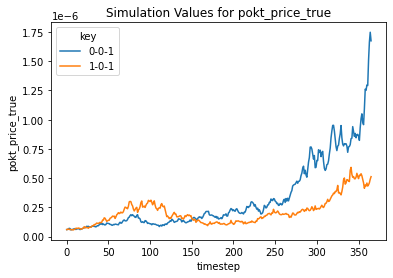

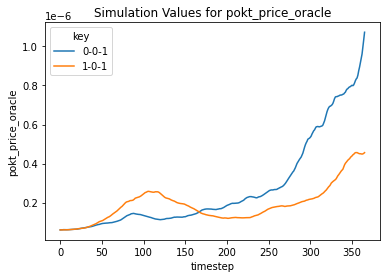

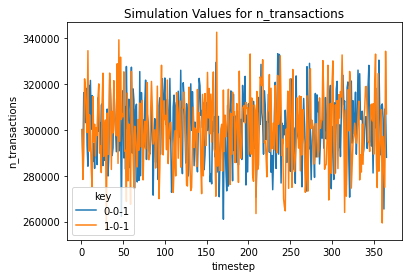

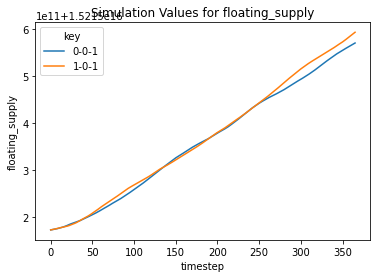

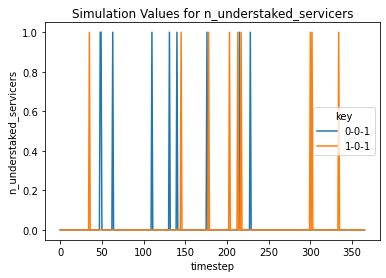

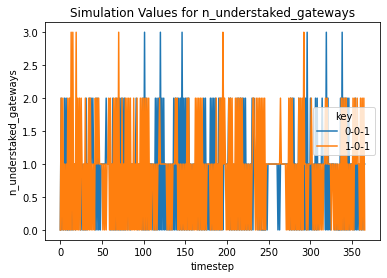

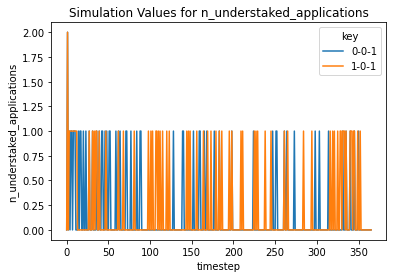

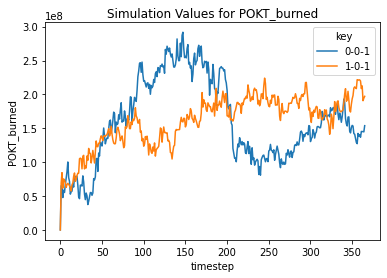

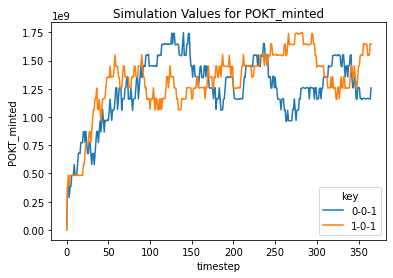

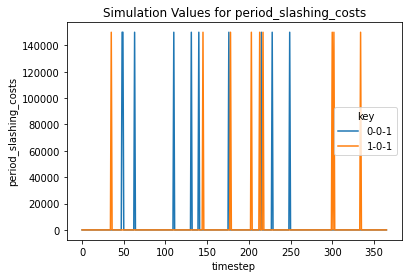

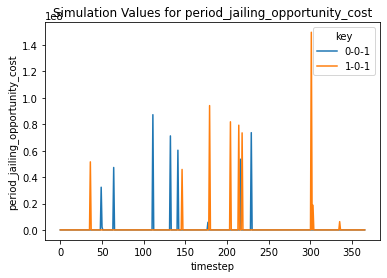

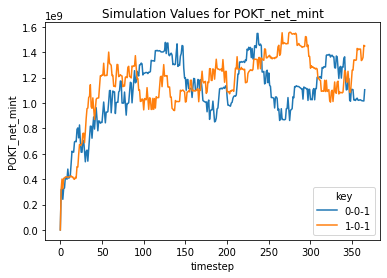

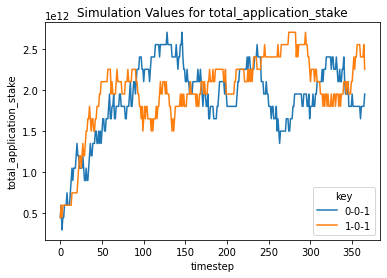

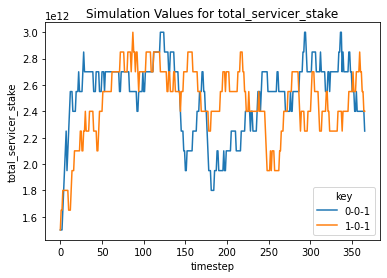

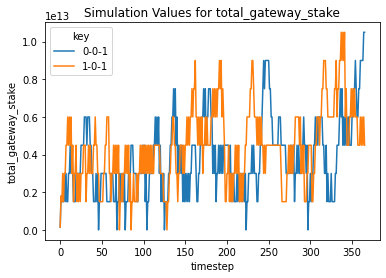

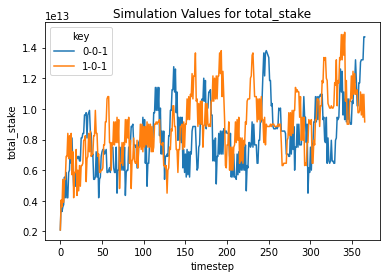

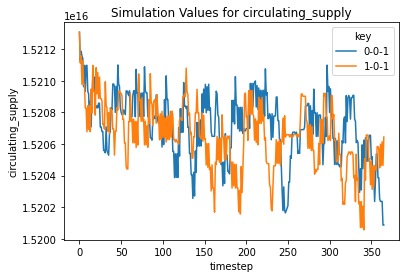

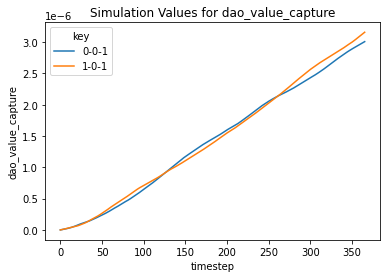

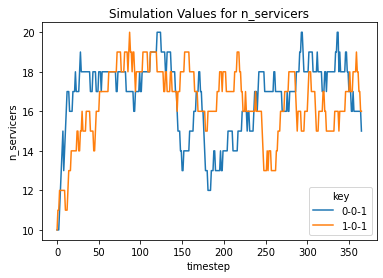

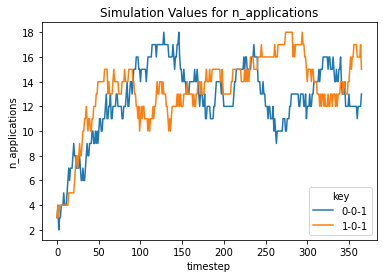

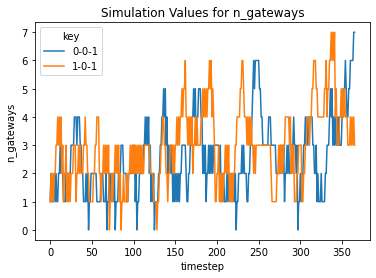

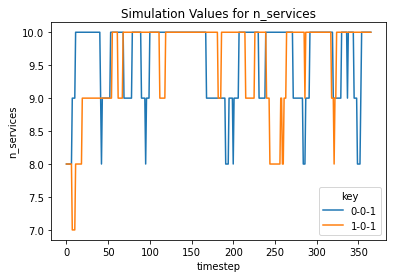

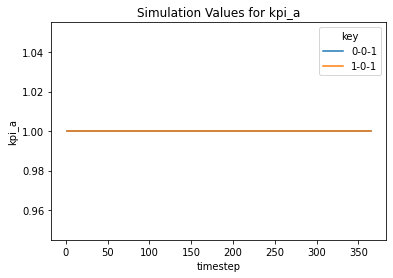

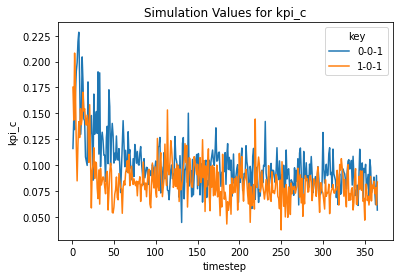

In [4]:
for col in ['total_relays', 'processed_relays', 'pokt_price_true', 'pokt_price_oracle',
           'n_transactions', 'floating_supply', 'n_understaked_servicers', 'n_understaked_gateways',
            'n_understaked_applications', 'POKT_burned', 'POKT_minted','period_slashing_costs',
            'period_jailing_opportunity_cost','POKT_net_mint', 'total_application_stake',
            'total_servicer_stake', 'total_gateway_stake', 'total_stake', 'circulating_supply',
            'dao_value_capture', 'n_servicers', 'n_applications', 'n_gateways',
           'n_services', 'kpi_a', 'kpi_c']:
    # Grab the pivot table
    table = df.pivot("timestep", "key", col)
    
    # Plot
    table.plot(kind = 'line')
    plt.xlabel("timestep")
    plt.ylabel(col)
    plt.title("Simulation Values for {}".format(col))
    
    plt.show()